# RUG Digital Humanities Thesis Project

### Mapping Governance Strategies for AI Sustainability: An Analysis of EU, USA, and China Regulatory Frameworks

Within this notebook, legal documents concerning AI governance from the European Union, United States, and People's Republic of China were analyzed. This process is part of the Thesis: **Mapping Governance Strategies for AI Sustainability: An Analysis of EU, USA, and China Regulatory Frameworks**. This thesis investigates the intersection of Artificial Intelligence (AI) and sustainability, focusing on how different jurisdictions balance the promotion of AI innovation with the need to address environmental and ethical considerations. By analyzing the regulatory frameworks of the EU, USA, and China, the study seeks to understand the strategies employed by these regions to tackle sustainability issues.

To perform this analysis, legal documents were collected and pre-processed to conduct seeded LDA topic modeling with tomotopy. Seeded LDA, focuses on specific concepts through predefined seed words, allowing for a more targeted exploration of AI-related sustainability topics. This method provides insights into how each region's legislative efforts align with sustainability principles and highlights areas where further improvements are needed. 

The corpus created from this process is further analyzed to uncover key themes and trends in AI governance. The analysis results in a detailed comparison of the regulatory approaches of the EU, USA, and China, offering valuable insights into the intersection of AI and sustainability. This notebook documents the entire process, from data collection and preprocessing to the application of seeded LDA and the interpretation of the results.

## Program's Code

### Preparation:

- STEP 1: We start by installing, importing, and downloading the necessary libraries for this project.

In [ ]:
# Install necessary libraries
!pip3 install tomotopy
!pip3 install pymupdf
!pip3 install nltk

# Import them
import os
import fitz
import tomotopy as tp
from tomotopy.coherence import Coherence
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


- STEP 2: Let us define the necessary functions that are going to be used later.

In [40]:
def preprocess(doc):
    """
    Preprocess the document by converting text to lowercase, tokenizing, and removing stopwords and non-alphabetic tokens.
    
    Parameters:
    doc (str): The document text to preprocess.
    
    Returns:
    list: A list of preprocessed tokens.
    """
    # Convert the document text to lowercase
    doc = doc.lower()
    
    # Tokenize the document into words
    tokens = word_tokenize(doc)
    
    # Filter out non-alphabetic tokens and stopwords
    tokens = [word for word in tokens if word.isalpha() and word not in custom_stopwords]
    
    return tokens  # Return the list of preprocessed tokens

def load_documents(folder_path):
    """
    Load and preprocess documents from the given folder path.
    
    Parameters:
    folder_path (str): The path to the folder containing the documents.
    
    Returns:
    list: A list of preprocessed document tokens.
    """
    documents = []  # Initialize an empty list to store document contents
    
    # Check if the specified folder exists
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return documents  # Return an empty list if the folder does not exist
    
    # Traverse the directory tree rooted at folder_path
    for root, dirs, files in os.walk(folder_path):
        # Iterate over all files in the current directory
        for filename in files:
            # Check if the file has a .pdf extension
            if filename.endswith(".pdf"):
                try:
                    file_path = os.path.join(root, filename)  # Construct the full file path
                    with fitz.open(file_path) as pdf_document:
                        text = ""
                        for page_num in range(pdf_document.page_count):
                            page = pdf_document.load_page(page_num)
                            text += page.get_text()
                        tokens = preprocess(text)  # Preprocess the document text into tokens
                        documents.append(tokens)  # Append the tokens to the list
                except Exception as e:
                    # Print an error message if there is an issue reading the file
                    print(f"Error reading {filename}: {e}")
    
    return documents  # Return the list of preprocessed document tokens


def calculate_tfidf(documents):
    """
    Calculate the TF-IDF scores for the given documents.
    
    Parameters:
    documents (list of list of str): A list of documents, where each document is represented as a list of tokens.
    
    Returns:
    dict: A dictionary where keys are words and values are their corresponding TF-IDF scores aggregated across all documents.
    """
    # Join tokens to form full document strings for each document
    documents = [' '.join(doc) for doc in documents]
    
    # Initialize the TF-IDF Vectorizer with the preprocess function as the tokenizer
    tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess)
    
    # Fit the vectorizer to the documents and transform the documents into TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
    
    # Get the feature names (words) from the vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Initialize an empty dictionary to store the aggregated TF-IDF scores
    tfidf_scores = {}
    
    # Iterate over each document in the TF-IDF matrix
    for doc_index in range(tfidf_matrix.shape[0]):
        # Get the non-zero TF-IDF feature indices for the document
        feature_index = tfidf_matrix[doc_index, :].nonzero()[1]
        
        # Zip the feature indices with their corresponding TF-IDF scores
        tfidf_doc_scores = zip(feature_index, [tfidf_matrix[doc_index, x] for x in feature_index])
        
        # Aggregate the TF-IDF scores for each word across all documents
        for word_index, score in tfidf_doc_scores:
            word = feature_names[word_index]  # Get the word corresponding to the feature index
            tfidf_scores[word] = tfidf_scores.get(word, 0) + score  # Accumulate the score for the word
    
    return tfidf_scores  # Return the dictionary of aggregated TF-IDF scores

def run_seeded_lda_with_tfidf(documents, num_topics, seed_topic_list, tfidf_scores, top_n_tfidf=10):
    """
    Run Seeded LDA with TF-IDF seed words on the given documents.
    
    Parameters:
    documents (list of list of str): A list of documents, where each document is represented as a list of tokens.
    num_topics (int): The number of topics to generate.
    seed_topic_list (dict): A dictionary where keys are topic names and values are lists of seed words for each topic.
    tfidf_scores (dict): A dictionary where keys are words and values are their corresponding TF-IDF scores.
    top_n_tfidf (int): The number of top TF-IDF words to add to each topic as seed words.
    
    Returns:
    tp.LDAModel: The trained LDA model.
    """
    # Initialize the LDA model with specified parameters
    model = tp.LDAModel(k=num_topics, alpha=0.1, eta=0.01, min_cf=5)
    
    # Add documents to the LDA model
    for doc in documents:
        model.add_doc(doc)
    
    # Enhance the seed_topic_list with highest TF-IDF words
    for topic_id, (topic, seed_words) in enumerate(seed_topic_list.items()):
        # Set priors for the given seed words in each topic
        for word in seed_words:
            if word in model.used_vocabs:
                word_id = model.used_vocabs[word]
                model.set_word_prior(topic_id, word_id, 1.0)  # High prior for given seed words
        
        # Add top N TF-IDF words to the seed words
        top_tfidf_words = sorted(tfidf_scores.items(), key=lambda item: item[1], reverse=True)[:top_n_tfidf]
        tfidf_seed_words = [word for word, score in top_tfidf_words if word not in seed_words]
        
        # Set lower priors for the top TF-IDF words
        for word in tfidf_seed_words:
            if word in model.used_vocabs:
                word_id = model.used_vocabs[word]
                model.set_word_prior(topic_id, word_id, 0.5)  # Lower prior for TF-IDF words

    # Train the model in iterations
    iterations = 50
    for i in range(0, 700, iterations):
        model.train(iterations)  # Train the model for a set number of iterations
        print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')  # Print log-likelihood for monitoring
    
    return model  # Return the trained LDA model

def calculate_coherence(model):
    """
    Calculate the coherence of the given model.
    
    Parameters:
    model (tp.LDAModel): The LDA model for which to calculate coherence.
    
    Returns:
    float: The coherence score of the model.
    """
    # Initialize the Coherence object with the model and specified coherence measure
    coherence = Coherence(model, coherence='c_v')
    
    # Calculate and return the coherence score
    return coherence.get_score()

def calculate_inclusivity(model):
    """
    Calculate the inclusivity of the given LDA model.
    
    Inclusivity is defined as the proportion of documents that include each topic.
    
    Parameters:
    model (tp.LDAModel): The trained LDA model.
    
    Returns:
    np.ndarray: An array representing the inclusivity of each topic.
    """
    # Initialize an array to count the number of documents that include each topic
    topic_counts = np.zeros(model.k)
    
    # Iterate over each document in the model
    for doc in model.docs:
        # Iterate over the topics in the document
        for t, _ in doc.get_topics():
            topic_counts[t] += 1  # Increment the count for the topic
    
    # Calculate inclusivity as the proportion of documents that include each topic
    inclusivity = topic_counts / len(model.docs)
    
    return inclusivity  # Return the inclusivity array


### Preprocessing, Loading Documents and TF-IDF Analysis:

- STEP 3: Below, we will define custom stop-words for the datasets and seed topics used for topic modeling.  

In [41]:
# Set custom stopwords and add them to the stopwords
custom_stopwords = set(stopwords.words('english')).union(set([
    'also', 'including', 'shall', 'body', 'article', 'ai', 'system', 'cod',
    'artificial', 'intelligence', 'etc', 'may', 'use', 'within', 'must', 'could',
    'state', 'national', 'eu', 'usa', 'us', 'prc', 'regulation', 'law', 'com',
    'eli', 'http', 'set', 'put', 'en', 'swd', 'vol', 'sec', 'iii', 'ii', 'i', 'b',
    'title', 'chapter', 'section', 'cc', 'de', 'europe', 'see', 'del', 'https',
    'et', 'act','new', 'data', 'used', 'would', 'european', 'commission', 'office',
    'member', 'states', 'union', 'united', 'systems', 'federal', 'directive',
    'services', 'service', 'relevant', 'secretary', 'subsection', 'risks', 'sector',
    'well', 'annex', 'example', 'ensure', 'parliament', 'oj', 'l', 'one', 'access',
    'r', 'al', 'e', 'c', 'sfmt', 'fmt', 'date', 'term', 'verdate', 'po', 'jkt', 
    'frm', 'council', 'department', 'director', 'appropriate', 'government', 
    'committee', 'agencies', 'paragraph', 'agency', 'legislation', 'legal', 'means',
    'rules', 'rights', 'policy', 'qs', 'sep', 'order', 'whether', 'without', 
    'later', 'vehicle', 'river', 'part', 'standard', 'available', 'comment'
]))

# Define seed topics
seed_topic_list = {
    'sustainability': ['sustainability', 'sustainable', 'development', 'eco-friendly', 'ecological', 'ecology', 'green'],
    'environmental_impact': ['environment', 'impact', 'carbon', 'footprint', 'greenhouse', 'climate', 'emissions', 'co2'],
    'energy_demand': ['energy', 'demand', 'consumption', 'resource', 'electricity', 'power', 'use', 'usage'],
    'water_consumption': ['water', 'consumption', 'usage', 'use', 'cooling', 'hydro', 'waste', 'waterwaste'],
    'accountability': ['accountability', 'responsibility', 'answerability', 'oversight', 'accountable']
}

- STEP 4: It is time to load the documents from the directories and verify that everything is loaded correctly. 

In [42]:
# Define subdirectories for each region
document_paths = {'EU': 'DATA/EU', 'USA': 'DATA/USA', 'PRC': 'DATA/PRC'}

# Load documents from the subdirectories
documents_by_region = {region: load_documents(path) for region, path in document_paths.items()}

# Print the loaded documents for verification
for region, docs in documents_by_region.items():
    print(f"{region} has {len(docs)} documents loaded.")
    

EU has 26 documents loaded.
USA has 24 documents loaded.
PRC has 14 documents loaded.


- STEP 5: Next, we will calculate the TF-IDF scores for each region and use them to enhance the accuracy of topic models. 

In [43]:
# Calculate TF-IDF scores
tfidf_scores = {region: calculate_tfidf(docs) for region, docs in documents_by_region.items()}

# Print top 10 TF-IDF words for each region's documents
print("Top 10 TF-IDF words for each region:")
for region, scores in tfidf_scores.items():
    top_tfidf_words = sorted(scores.items(), key=lambda item: item[1], reverse=True)[:10]
    print(f"\nRegion: {region}")
    for word, score in top_tfidf_words:
        print(f"{word}: {score:.4f}")
        

Top 10 TF-IDF words for each region:

Region: EU
digital: 3.3092
public: 2.5686
development: 2.0712
support: 1.7031
market: 1.6518
sustainable: 1.3115
innovation: 1.2258
requirements: 1.2246
climate: 1.1781
technologies: 1.1656

Region: USA
information: 1.7166
development: 1.4470
research: 1.4138
public: 1.3629
security: 1.3319
technology: 1.2825
automated: 1.1952
defense: 1.1178
risk: 1.1088
critical: 1.0331

Region: PRC
development: 2.1405
security: 1.4944
technology: 1.3345
promote: 1.1870
research: 1.1669
information: 1.1466
innovation: 1.1009
providers: 0.9653
public: 0.9341
improve: 0.9264


### Training the Models:

- STEP 6: All is set to start and run topic modeling. 

**!!!** *Please remember that the order of clusters and metrics in the output may differ slightly from the results presented in the thesis, as the models are being re-trained every time this code is run*. 

In [44]:
# Run the topic modeling and print results
num_topics = 5 # Number of topics
num_topic_words = 15 # Number of top words per topic
top_n_tfidf = 10  # Number of top TF-IDF words to add to seed topics
results_tfidf = {}
topics = {}

for region, docs in documents_by_region.items():
    print(f"\nProcessing region: {region}")
    model_tfidf = run_seeded_lda_with_tfidf(docs, num_topics, seed_topic_list, tfidf_scores[region], top_n_tfidf)
    coherence_tfidf = calculate_coherence(model_tfidf)
    perplexity_tfidf = model_tfidf.perplexity
    inclusivity_tfidf = calculate_inclusivity(model_tfidf)
    
    results_tfidf[region] = {
        'model': model_tfidf, 
        'coherence': coherence_tfidf, 
        'perplexity': perplexity_tfidf, 
        'inclusivity': inclusivity_tfidf
    }

    print(f"\nTOPICS for {region}:\n")
    topics[region] = {}
    for topic_number in range(num_topics):
        topic_words_tfidf = [word for word, _ in model_tfidf.get_topic_words(topic_number, top_n=num_topic_words)]
        topics[region][topic_number] = topic_words_tfidf
        print(f"Topic {topic_number + 1}: {' '.join(topic_words_tfidf)}")

    # Print coherence, perplexity, and inclusivity
    print(f'\nCoherence: {coherence_tfidf}')
    print(f'Perplexity: {perplexity_tfidf}')
    print(f'Inclusivity: {inclusivity_tfidf}')

    # Save and load the model
    model_path = f'{region}_model_tfidf.bin'
    model_tfidf.save(model_path)
    loaded_model_tfidf = tp.LDAModel.load(model_path)
    print(f'Model for {region} saved and loaded successfully.')



Processing region: EU
Iteration: 0	Log-likelihood: -7.594845503885922
Iteration: 50	Log-likelihood: -7.552615420316838
Iteration: 100	Log-likelihood: -7.544337658886656
Iteration: 150	Log-likelihood: -7.544997614038986
Iteration: 200	Log-likelihood: -7.543771367135573
Iteration: 250	Log-likelihood: -7.539748611928362
Iteration: 300	Log-likelihood: -7.541169360023585
Iteration: 350	Log-likelihood: -7.545171416289877
Iteration: 400	Log-likelihood: -7.548679917501809
Iteration: 450	Log-likelihood: -7.552085838121551
Iteration: 500	Log-likelihood: -7.5535539922254875
Iteration: 550	Log-likelihood: -7.555853203614335
Iteration: 600	Log-likelihood: -7.561527940086031
Iteration: 650	Log-likelihood: -7.559327402549143

TOPICS for EU:

Topic 1: digital development support sustainable public climate countries innovation energy action investment key global promote technologies
Topic 2: solution ict assessment impact effects net carbon solutions emissions reference scenario methodology implementa

### Visualizations:
Since the models' training was successful, it is now time for visualizations to get a better sense of both the dataset utilized and the results of the trained models.
- STEP 7: The code below combines all the datasets into one in order to compare them and get some statistics. 

Combined Dataset Statistics:
Average Document Length: 6973.20 words
Minimum Document Length: 253 words
Maximum Document Length: 31945 words


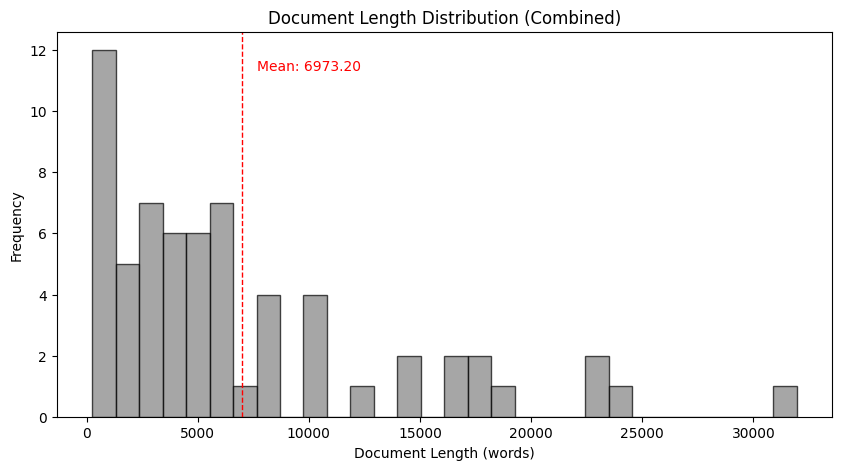

In [55]:
# Combine all document lengths from different regions
all_doc_lengths = []
for region, docs in documents_by_region.items():
    doc_lengths = [len(doc) for doc in docs]
    all_doc_lengths.extend(doc_lengths)

# Calculate statistics
average_length = np.mean(all_doc_lengths)
min_length = np.min(all_doc_lengths)
max_length = np.max(all_doc_lengths)

# Print the results
print(f"Combined Dataset Statistics:")
print(f"Average Document Length: {average_length:.2f} words")
print(f"Minimum Document Length: {min_length} words")
print(f"Maximum Document Length: {max_length} words")

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(all_doc_lengths, bins=30, edgecolor='black', alpha=0.7, color='grey')
plt.axvline(average_length, color='red', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(average_length * 1.1, max_ylim * 0.9, 'Mean: {:.2f}'.format(average_length), color='red')

plt.title('Document Length Distribution (Combined)')
plt.xlabel('Document Length (words)')
plt.ylabel('Frequency')
plt.show()


Now, let us compare the separate datasets.

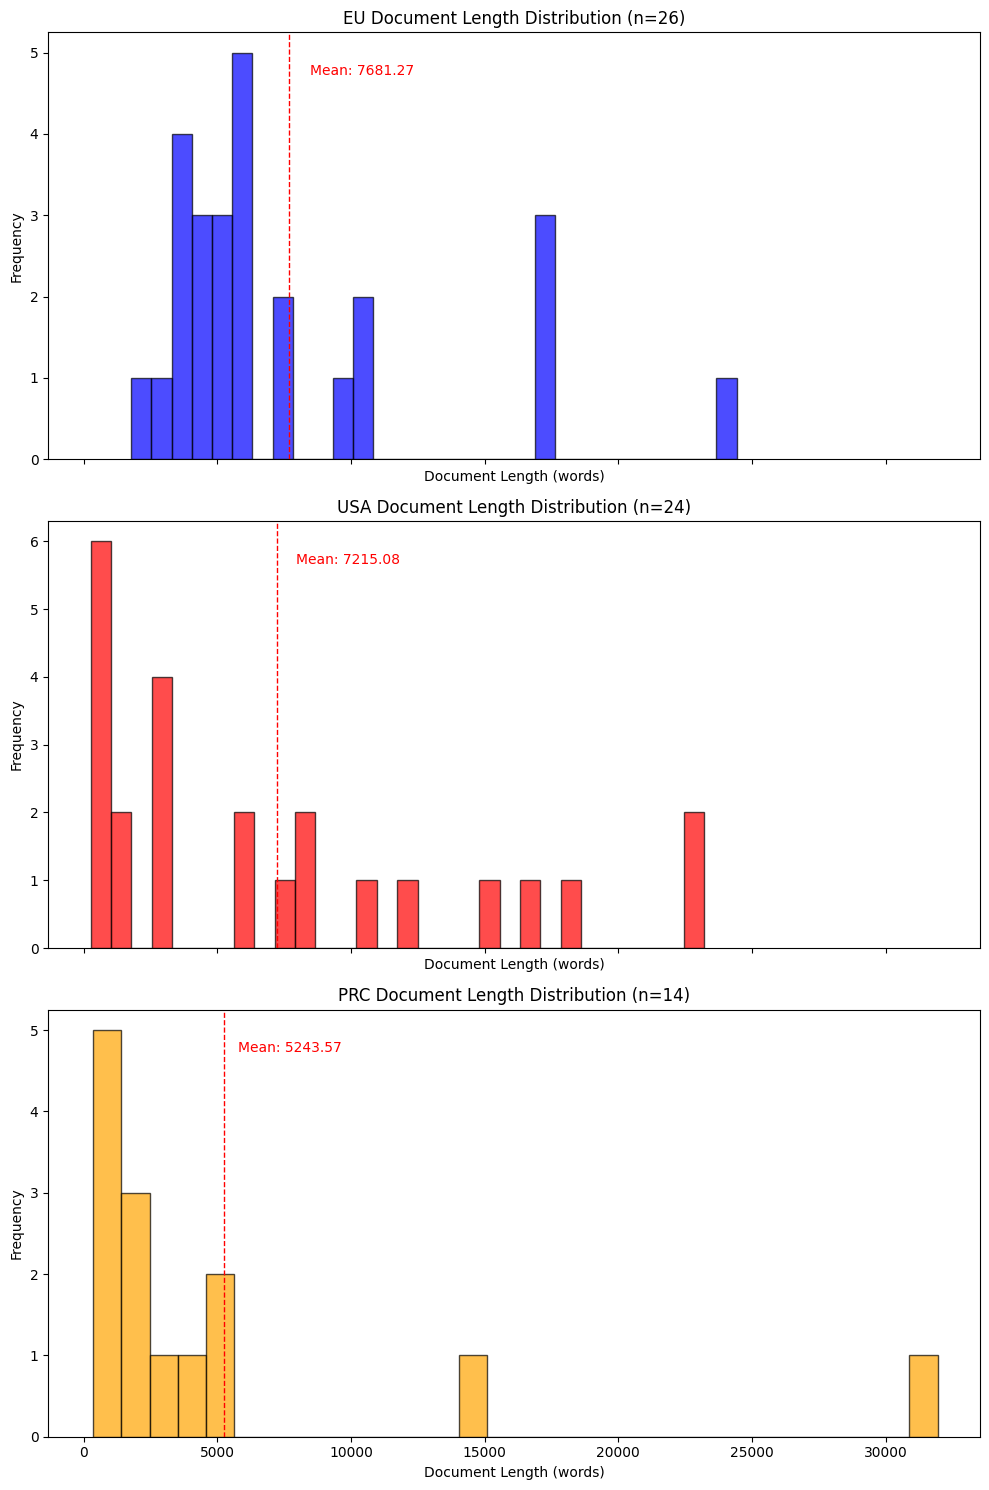

In [56]:
def plot_combined_document_length_distribution(docs_dict, colors):
    """
    Plot the document length distribution for each region in a combined plot.
    
    Parameters:
    docs_dict (dict): A dictionary where keys are region names and values are lists of preprocessed documents.
    colors (list): A list of colors to use for each region in the plot.
    """
    num_regions = len(docs_dict)  # Number of regions
    fig, axes = plt.subplots(num_regions, 1, figsize=(10, 5 * num_regions), sharex=True)  # Create subplots

    # Ensure axes is a list if there's only one region
    if num_regions == 1:
        axes = [axes]

    # Iterate over regions, their documents, and assigned colors
    for ax, (region, docs), color in zip(axes, docs_dict.items(), colors):
        doc_lengths = [len(doc) for doc in docs]  # Calculate document lengths
        average_length = np.mean(doc_lengths)  # Calculate average document length
        num_documents = len(docs)  # Number of documents

        # Plot histogram of document lengths
        ax.hist(doc_lengths, bins=30, edgecolor='black', alpha=0.7, color=color)
        # Plot a red dashed line for the average length
        ax.axvline(average_length, color='red', linestyle='dashed', linewidth=1)

        # Annotate the average length on the plot
        min_ylim, max_ylim = ax.get_ylim()
        ax.text(average_length * 1.1, max_ylim * 0.9, 'Mean: {:.2f}'.format(average_length), color='red')
        
        # Set plot titles and labels
        ax.set_title(f'{region} Document Length Distribution (n={num_documents})')
        ax.set_xlabel('Document Length (words)')
        ax.set_ylabel('Frequency')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plot

# Define colors for each region
colors = ['blue', 'red', 'orange']

# Combine and plot document length distribution for all regions
plot_combined_document_length_distribution(documents_by_region, colors)


- STEP 8: This code creates a bar plot to compare coherence scores by region.

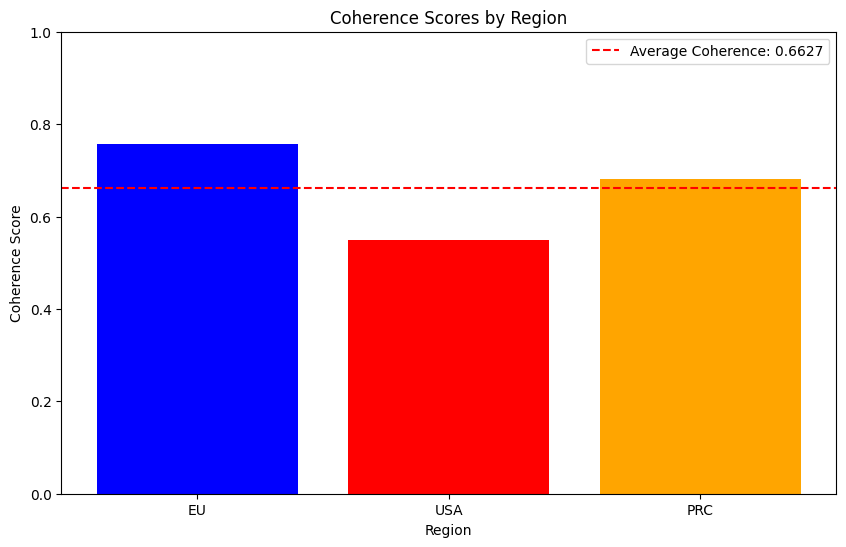

In [60]:
import matplotlib.pyplot as plt

# Extract coherence scores for each region
coherence_scores = {region: results_tfidf[region]['coherence'] for region in results_tfidf}

# Calculate the average coherence score
average_coherence = sum(coherence_scores.values()) / len(coherence_scores)

# Plot the coherence scores
plt.figure(figsize=(10, 6))
plt.bar(coherence_scores.keys(), coherence_scores.values(), color=['blue', 'red', 'orange'])

# Plot the average coherence score as a red dashed line
plt.axhline(y=average_coherence, color='red', linestyle='--', label=f'Average Coherence: {average_coherence:.4f}')

plt.xlabel('Region')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores by Region')
plt.ylim(0, 1)  # Assuming coherence scores range between 0 and 1
plt.legend()
plt.show()


To get even more insights about the coherence score across regions and their topics. 

In [46]:
# Calculate coherence for each document set, print metrics
coherences = {}
min_coherences = {}
max_coherences = {}

for region, result in results_tfidf.items():
    model = result['model']
    coherence = tp.coherence.Coherence(model, coherence='c_v')
    average_coherence = coherence.get_score()
    coherence_per_topic = [coherence.get_score(topic_id=k) for k in range(model.k)]
    min_coherence = min(coherence_per_topic)
    max_coherence = max(coherence_per_topic)
    
    print(f'\n==== Coherence for {region}: c_v ====')
    print('Average:', average_coherence)
    print('Minimum:', min_coherence)
    print('Maximum:', max_coherence)
    print('\nPer Topic:')
    for i, score in enumerate(coherence_per_topic):
        print(f'Topic {i + 1}: {score}')
    
    coherences[region] = average_coherence
    min_coherences[region] = min_coherence
    max_coherences[region] = max_coherence

# Calculate the average coherence across all regions
average_coherence_total = np.mean(list(coherences.values()))
print(f'\nAverage coherence across all regions: {average_coherence_total}\n')



==== Coherence for EU: c_v ====
Average: 0.7575740349292756
Minimum: 0.6958176672458649
Maximum: 0.9074714064598084

Per Topic:
Topic 1: 0.7310012489557266
Topic 2: 0.9074714064598084
Topic 3: 0.6958176672458649
Topic 4: 0.7548814207315445
Topic 5: 0.6986984312534332

==== Coherence for USA: c_v ====
Average: 0.5495430824160575
Minimum: 0.42937860935926436
Maximum: 0.6687438085675239

Per Topic:
Topic 1: 0.6687438085675239
Topic 2: 0.5116440713405609
Topic 3: 0.5327440902590752
Topic 4: 0.6052048325538635
Topic 5: 0.42937860935926436

==== Coherence for PRC: c_v ====
Average: 0.6809988483786583
Minimum: 0.5991291522979736
Maximum: 0.7634694218635559

Per Topic:
Topic 1: 0.7634694218635559
Topic 2: 0.5991291522979736
Topic 3: 0.6216538742184639
Topic 4: 0.6999286830425262
Topic 5: 0.7208131104707718

Average coherence across all regions: 0.6627053219079971



### Other: 
This code was used to count the number of pages across all of the documents used for the study.

In [67]:
# Install PyMuPDF
!pip3 install PyMuPDF

def count_pdf_pages(base_path='DATA'):
    """
    Count the total number of pages in all PDF files within the specified subdirectories.
    
    Parameters:
    base_path (str): The base directory containing the 'EU', 'USA', and 'PRC' subdirectories.
    
    Returns:
    int: The total number of pages in all PDF files.
    """
    total_pages = 0
    # Iterate over the subdirectories for each region
    for folder in ['EU', 'USA', 'PRC']:
        folder_path = os.path.join(base_path, folder)  # Construct the full folder path
        for filename in os.listdir(folder_path):  # List files in the directory
            if filename.endswith('.pdf'):  # Check for PDF files
                file_path = os.path.join(folder_path, filename)  # Construct the full file path
                try:
                    pdf_document = fitz.open(file_path)  # Open the PDF document
                    total_pages += pdf_document.page_count  # Add the page count to the total
                except Exception as e:
                    # Print an error message if there is an issue reading the file
                    print(f"Could not read {file_path}: {e}")
    return total_pages

# Count the total number of pages
total_pages = count_pdf_pages()
print(f"Total number of pages in all PDF files: {total_pages}")


Total number of pages in all PDF files: 2325


### Extras: 

This part of the notebook contains parts of the research not mentioned in the paper but provides more exciting discoveries for this study. For example, the first cell trains a Word2Vec model to explore semantic relationships between words within the identified topics.

In [62]:
from gensim.models import Word2Vec

def train_word2vec_model(documents):
    """
    Train a Word2Vec model on the given documents.
    """
    return Word2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)

def get_topics(model, num_topics, num_topic_words):
    """
    Retrieve topics and their top words from the LDA model.
    """
    topics = {}
    for topic_id in range(num_topics):
        words = model.get_topic_words(topic_id, top_n=num_topic_words)
        topics[topic_id] = [word for word, _ in words]
    return topics

def explore_semantic_relationships(word2vec_model, topics):
    """
    Explore the semantic relationships between words within the identified topics using Word2Vec.
    """
    for topic_num, words in topics.items():
        print(f"Topic {topic_num + 1}:")
        for word in words:
            if word in word2vec_model.wv.key_to_index:
                similar_words = word2vec_model.wv.most_similar(word, topn=10)
                print(f"  {word}: {[w for w, _ in similar_words]}")
            else:
                print(f"  {word} not in vocabulary")
        print("\n")

def most_similar_and_distance(word2vec_model, word, word1, word2):
    """
    Find most similar words to a specified word and calculate distance between two specified words.
    """
    if word in word2vec_model.wv.key_to_index:
        most_similar_words = word2vec_model.wv.most_similar(word)
        print(f"Words most similar to '{word}':")
        for similar_word, similarity in most_similar_words:
            print(f"{similar_word}: {similarity}")
    else:
        print(f"Word '{word}' not in vocabulary")
    
    if word1 in word2vec_model.wv.key_to_index and word2 in word2vec_model.wv.key_to_index:
        distance = word2vec_model.wv.distance(word1, word2)
        print(f"Distance between '{word1}' and '{word2}': {distance}")
    else:
        print(f"One or both words '{word1}' and '{word2}' not in vocabulary")

# Assuming 'documents_by_region' and 'results_tfidf' are loaded from previous cell
num_topics = 5
num_topic_words = 15

# Train and save the word2vec models for each region
word2vec_models = {}

for region, docs in documents_by_region.items():
    print(f"\nExploring semantic relationships for region: {region}")
    word2vec_model = train_word2vec_model(docs)
    word2vec_models[region] = word2vec_model  # Save the model for later use
    
    lda_model = results_tfidf[region]['model']
    topics = get_topics(lda_model, num_topics, num_topic_words)
    
    explore_semantic_relationships(word2vec_model, topics)
    
    # Example analysis for specific words
    word = 'sustainability'
    word1 = 'sustainability'
    word2 = 'technology'
    most_similar_and_distance(word2vec_model, word, word1, word2)




Exploring semantic relationships for region: EU
Topic 1:
  digital: ['green', 'economy', 'transition', 'energy', 'innovation', 'deal', 'climate', 'technologies', 'sustainable', 'investment']
  development: ['support', 'sustainable', 'innovation', 'investment', 'action', 'promote', 'economy', 'global', 'digital', 'unlock']
  support: ['investment', 'innovation', 'unlock', 'global', 'promote', 'development', 'skills', 'economy', 'action', 'research']
  sustainable: ['development', 'innovation', 'digital', 'support', 'economy', 'investment', 'green', 'climate', 'energy', 'transition']
  public: ['governed', 'organisations', 'supervision', 'supervisory', 'altruism', 'registration', 'bodies', 'designate', 'register', 'notify']
  climate: ['energy', 'transition', 'economy', 'green', 'deal', 'global', 'skills', 'investment', 'circular', 'digital']
  countries: ['promote', 'inclusive', 'msmes', 'promoting', 'developing', 'partners', 'sdgs', 'cooperation', 'agenda', 'finance']
  innovation: ['

This part of the code plots every region's top 20 most frequent terms.

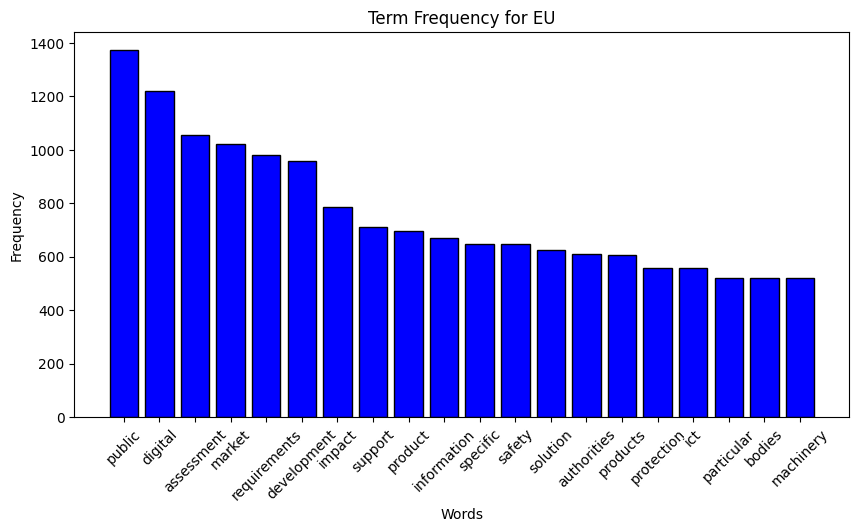

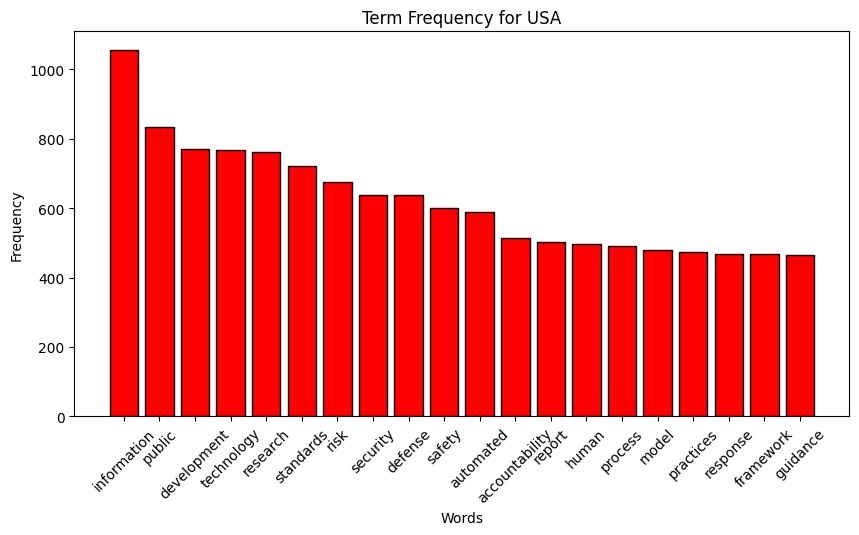

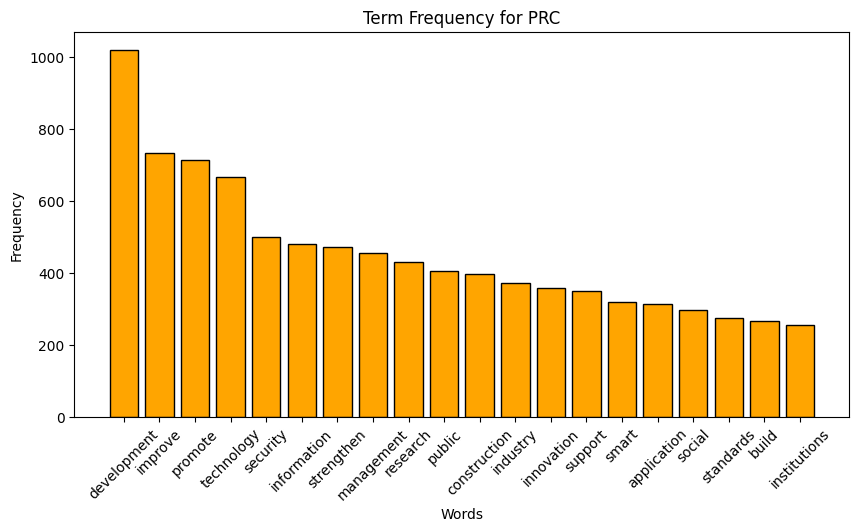

In [64]:
from collections import Counter

def plot_term_frequency(docs, title, color, top_n=20):
    """
    Plot the term frequency for the given documents.
    
    Parameters:
    docs (list of list of str): A list of documents, where each document is represented as a list of tokens.
    title (str): The title for the plot.
    color (str): The color for the bars in the plot.
    top_n (int): The number of top terms to display.
    """
    # Flatten the list of documents into a single list of words
    all_words = [word for doc in docs for word in doc]
    
    # Calculate the frequency of each word
    word_freq = Counter(all_words)
    
    # Get the most common words and their frequencies
    common_words = word_freq.most_common(top_n)
    words, counts = zip(*common_words)
    
    # Plot the term frequencies
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts, edgecolor='black', color=color)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Define colors for each region
colors = {'EU': 'blue', 'USA': 'red', 'PRC': 'orange'}

# Plot term frequency for each region
for region, docs in documents_by_region.items():
    plot_term_frequency(docs, f'Term Frequency for {region}', colors[region])